In [1]:
import numpy as np
from typing import Tuple
from scipy import special
from sklearn import metrics
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import tensorflow as tf
import tensorflow_privacy as tfp

import tensorflow_datasets as tfds

# Set verbosity.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

/home/wayne/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResultsCollection
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyMetric
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyReportMetadata
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report

In [3]:
dataset = 'cifar10'
num_classes = 10
activation = 'relu'
num_conv = 3

batch_size=50
epochs_per_report = 2
total_epochs = 50

lr = 0.001

l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 50

In [4]:
print('Loading the dataset.')
train_ds = tfds.as_numpy(
    tfds.load(dataset, split=tfds.Split.TRAIN, batch_size=-1))
test_ds = tfds.as_numpy(
    tfds.load(dataset, split=tfds.Split.TEST, batch_size=-1))
x_train = train_ds['image'].astype('float32') / 255.
y_train_indices = train_ds['label'][:, np.newaxis]
x_test = test_ds['image'].astype('float32') / 255.
y_test_indices = test_ds['label'][:, np.newaxis]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train_indices, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_indices, num_classes)

input_shape = x_train.shape[1:]

assert x_train.shape[0] % batch_size == 0, "The tensorflow_privacy optimizer doesn't handle partial batches"

Loading the dataset.


2023-03-21 19:07:26.114611: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-21 19:07:26.114636: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ISLabMileAMinuteWeed
2023-03-21 19:07:26.114641: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ISLabMileAMinuteWeed
2023-03-21 19:07:26.114698: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.43.4
2023-03-21 19:07:26.114714: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.43.4
2023-03-21 19:07:26.114719: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.43.4
2023-03-21 19:07:26.114886: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the follow

In [5]:
def NOsmall_cnn(input_shape: Tuple[int],
              num_classes: int,
              num_conv: int,
              activation: str = 'relu') -> tf.keras.models.Sequential:
  """Setup a small CNN for image classification.

  Args:
    input_shape: Integer tuple for the shape of the images.
    num_classes: Number of prediction classes.
    num_conv: Number of convolutional layers.
    activation: The activation function to use for conv and dense layers.

  Returns:
    The Keras model.
  """
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))

  # Conv layers
  for _ in range(num_conv):
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation=activation))
  model.add(tf.keras.layers.Dense(num_classes))

  model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy'])

  return model

def DPsmall_cnn(input_shape: Tuple[int],
              num_classes: int,
              num_conv: int,
              activation: str = 'relu') -> tf.keras.models.Sequential:
  """Setup a small CNN for image classification.

  Args:
    input_shape: Integer tuple for the shape of the images.
    num_classes: Number of prediction classes.
    num_conv: Number of convolutional layers.
    activation: The activation function to use for conv and dense layers.

  Returns:
    The Keras model.
  """
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))

  # Conv layers
  for _ in range(num_conv):
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation=activation))
  model.add(tf.keras.layers.Dense(num_classes))

  model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE),
    optimizer=tfp.DPKerasSGDOptimizer(
                  l2_norm_clip=l2_norm_clip,
                  noise_multiplier=noise_multiplier,
                  num_microbatches=num_microbatches,
                  learning_rate=lr),
    metrics=['accuracy'])

  return model

In [6]:
NOmodel_2layers = NOsmall_cnn(
    input_shape, num_classes, num_conv=2, activation=activation)
NOmodel_3layers = NOsmall_cnn(
    input_shape, num_classes, num_conv=3, activation=activation)

DPmodel_2layers = DPsmall_cnn(
    input_shape, num_classes, num_conv=2, activation=activation)
DPmodel_3layers = DPsmall_cnn(
    input_shape, num_classes, num_conv=3, activation=activation)

In [7]:
class PrivacyMetrics(tf.keras.callbacks.Callback):
  def __init__(self, epochs_per_report, model_name):
    self.epochs_per_report = epochs_per_report
    self.model_name = model_name
    self.attack_results = []

  def on_epoch_end(self, epoch, logs=None):
    epoch = epoch+1

    if epoch % self.epochs_per_report != 0:
      return

    print(f'\nRunning privacy report for epoch: {epoch}\n')

    logits_train = self.model.predict(x_train, batch_size=batch_size)
    logits_test = self.model.predict(x_test, batch_size=batch_size)

    prob_train = special.softmax(logits_train, axis=1)
    prob_test = special.softmax(logits_test, axis=1)

    # Add metadata to generate a privacy report.
    privacy_report_metadata = PrivacyReportMetadata(
        # Show the validation accuracy on the plot
        # It's what you send to train_accuracy that gets plotted.
        accuracy_train=logs['val_accuracy'], 
        accuracy_test=logs['val_accuracy'],
        epoch_num=epoch,
        model_variant_label=self.model_name)

    attack_results = mia.run_attacks(
        AttackInputData(
            labels_train=y_train_indices[:, 0],
            labels_test=y_test_indices[:, 0],
            probs_train=prob_train,
            probs_test=prob_test),
        SlicingSpec(entire_dataset=True, by_class=True),
        attack_types=[AttackType.LOGISTIC_REGRESSION],
        privacy_report_metadata=privacy_report_metadata)

    self.attack_results.append(attack_results)

In [8]:
all_reports = []
callback = PrivacyMetrics(epochs_per_report, "Normal 2 Layers")
history = NOmodel_2layers.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=total_epochs,
      validation_data=(x_test, y_test),
      callbacks=[callback],
      shuffle=True)

all_reports.extend(callback.attack_results)

callback = PrivacyMetrics(epochs_per_report, "Normal 3 Layers")
history = NOmodel_3layers.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=total_epochs,
      validation_data=(x_test, y_test),
      callbacks=[callback],
      shuffle=True)

all_reports.extend(callback.attack_results)

callback = PrivacyMetrics(epochs_per_report, "DP 2 Layers")
history = DPmodel_2layers.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=total_epochs,
      validation_data=(x_test, y_test),
      callbacks=[callback],
      shuffle=True)

all_reports.extend(callback.attack_results)

callback = PrivacyMetrics(epochs_per_report, "DP 3 Layers")
history = DPmodel_3layers.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=total_epochs,
      validation_data=(x_test, y_test),
      callbacks=[callback],
      shuffle=True)

all_reports.extend(callback.attack_results)

Epoch 1/50
1000/1000 [==============================] - 7s 7ms/step - loss: 1.5540 - accuracy: 0.4418 - val_loss: 1.3342 - val_accuracy: 0.5219
Epoch 2/50
 994/1000 [============================>.] - ETA: 0s - loss: 1.2072 - accuracy: 0.5739
Running privacy report for epoch: 2

1000/1000 [==============================] - 12s 12ms/step - loss: 1.2069 - accuracy: 0.5739 - val_loss: 1.1437 - val_accuracy: 0.5966
Epoch 3/50
1000/1000 [==============================] - 7s 7ms/step - loss: 1.0845 - accuracy: 0.6203 - val_loss: 1.0602 - val_accuracy: 0.6325
Epoch 4/50
 993/1000 [============================>.] - ETA: 0s - loss: 0.9998 - accuracy: 0.6514
Running privacy report for epoch: 4

1000/1000 [==============================] - 12s 12ms/step - loss: 0.9999 - accuracy: 0.6513 - val_loss: 1.0196 - val_accuracy: 0.6464
Epoch 5/50
1000/1000 [==============================] - 7s 7ms/step - loss: 0.9409 - accuracy: 0.6722 - val_loss: 1.0317 - val_accuracy: 0.6408
Epoch 6/50
 993/1000 [======

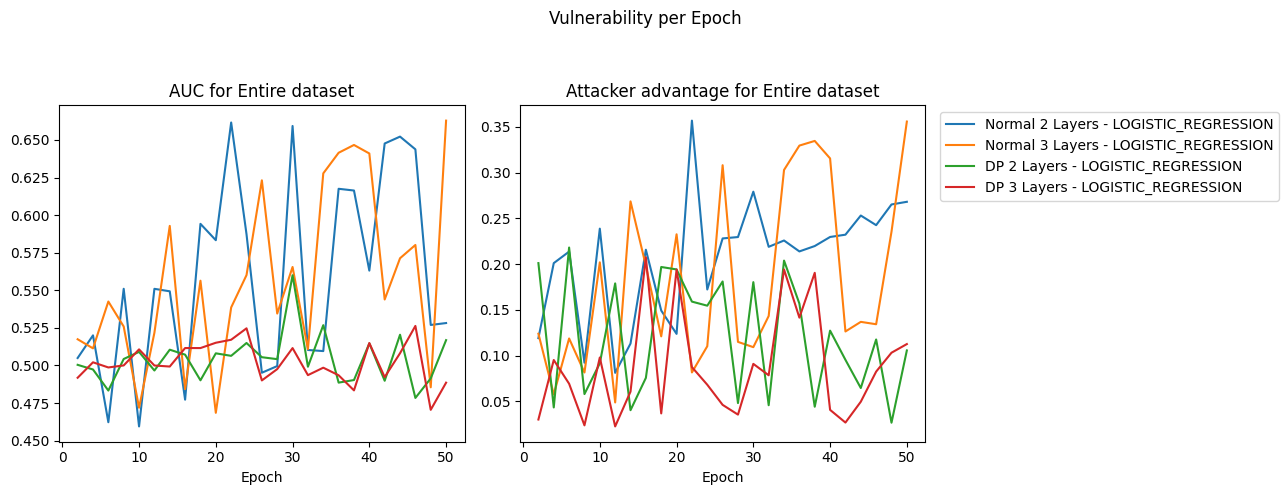

In [9]:
results = AttackResultsCollection(all_reports)
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(
    results, privacy_metrics=privacy_metrics)

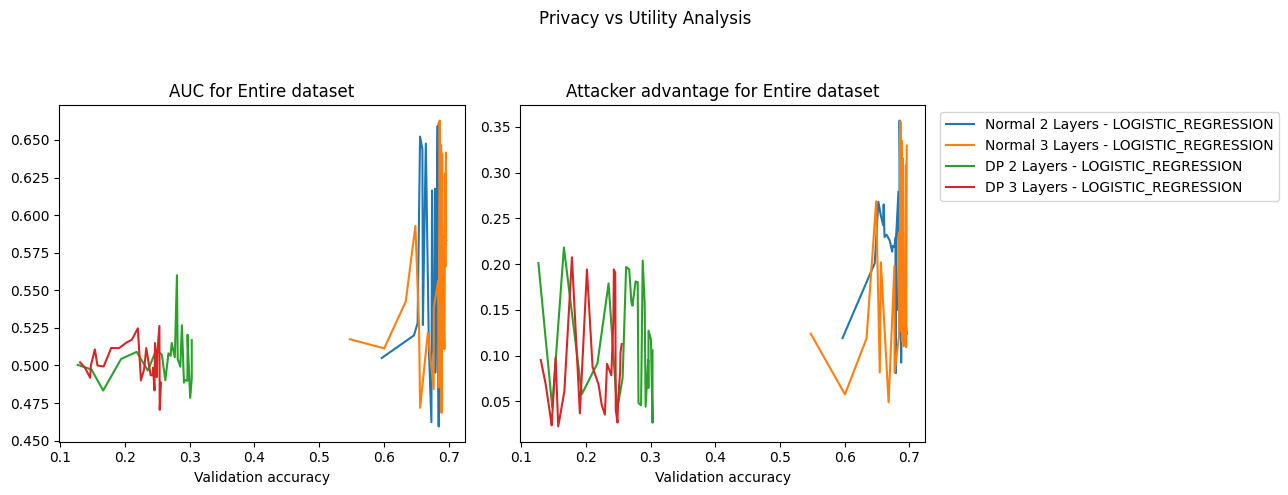

In [10]:
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
utility_privacy_plot = privacy_report.plot_privacy_vs_accuracy(
    results, privacy_metrics=privacy_metrics)

for axis in utility_privacy_plot.axes:
  axis.set_xlabel('Validation accuracy')